<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-7/1.Data%20Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7: Explaining a PyTorch Image Classifier

## <font color=green>**Data Preparation**</font>

## 1. Setting the environment

If you are using Colab, it comes preinstalled with PyTorch and other commonly used libraries for machine and Deep learning. However if you are executing this notebook in your local system, you will need to install them manually via the following commands:



In [6]:
!pip3 install torch torchvision numpy pandas matplotlib seaborn scikit-learn --quiet


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [7]:
# Importing the necessary libraries 
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, ConcatDataset

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


## 2. Loading the dataset

We'll create an image classifier to diagnose pneumonia in Chest X-Ray images The dataset we’ll use for training has been taken from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia), and it consists of 5,863 X-Ray images of patients, which have been split into two distinct categories — one containing pneumonia and the other being normal. In this ection, we'll have a look at the dataset and see if there are any issues with it.

> Download the [zipped dataset from Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) and save it as `chest_xray_original.zip` on your local systems

In [14]:
import zipfile
with zipfile.ZipFile("chest_xray_original.zip","r") as zip_ref:
    zip_ref.extractall("chest_xray_original")

In [21]:

# Assigning PATH to original dataset
PATH_original = 'chest_xray_original/chest_xray_original'


In [22]:
def distribution(data_set):
    #To calculate distribution of the datasets
    
    normal_path = os.path.join(PATH_original+f"/{data_set}/NORMAL")
    pneumonia_path = os.path.join(PATH_original+f"/{data_set}/PNEUMONIA")
  
    normal = len([filename for filename in os.listdir(normal_path)])
    pneumonia = len([filename for filename in os.listdir(pneumonia_path)])

    distribution = dict(zip(['Normal','Pneumonia'],[normal,pneumonia]))
    sns.barplot(x=list(distribution.keys()), y=list(distribution.values())).set_title(f"{data_set} Data Imbalance")
    return distribution

{'Normal': 1342, 'Pneumonia': 3876}

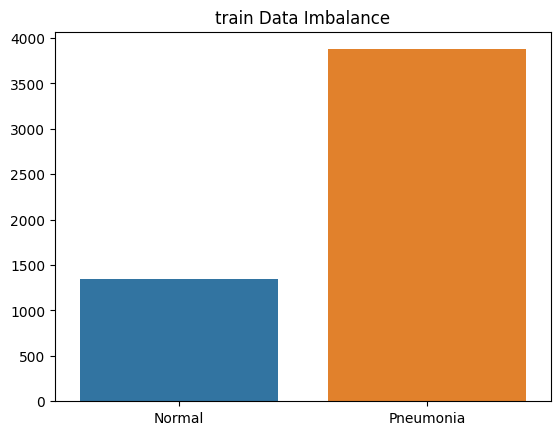

In [23]:
distribution('train')

{'Normal': 234, 'Pneumonia': 390}

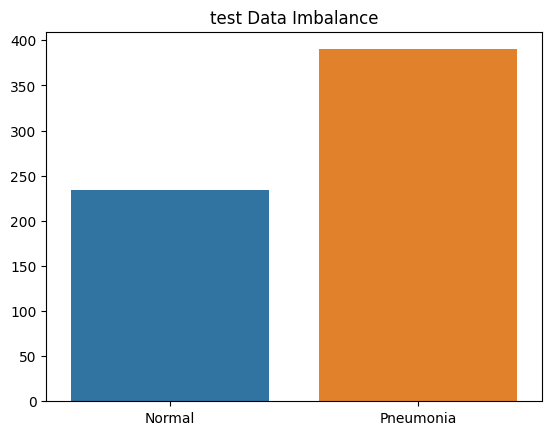

In [24]:
distribution('test')

{'Normal': 9, 'Pneumonia': 9}

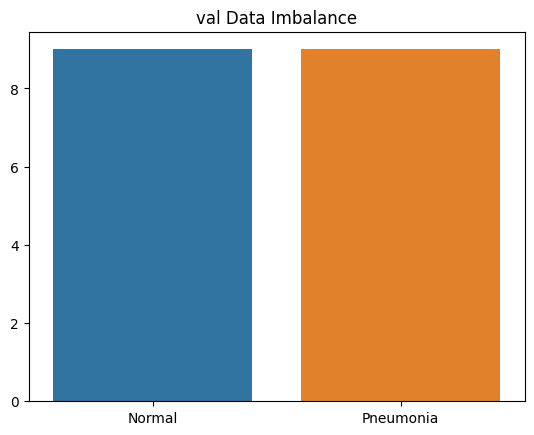

In [25]:
distribution('val')

Like many datasets in medical applications, this data has a class imbalance problem. Another cause of the concern is the presence of very few images validation set. The validation dataset consists of only 9 images for Pneumonia class and another 9 for the Normal class. This is not a sufficient number to adequately validate the model. We have to address these and other issues before proceeding with training our model.

> <mark>We will manually transfer 461 Normal and 498 Pneumonia unique images from training folder to the validation folder. </mark>
    
*Download and place the preprocessed dataset in a folder named `chest_xray_preprocessed`. The preprocessed dataset can be accessed from [here](https://drive.google.com/drive/folders/1-hvJdh-tONZHYFVdA3ttpB_yuRusZK5C?usp=sharing).*
 

## 3. Oversampling the data

We'll now augment the remaining training set of the preprocessed dataset by oversampling the minority class inorder to balance the classes

In [32]:
TRAIN_DIR = 'chest_xray_preprocessed/train'

IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 32
NUM_WORKERS = 4 # Number of parallel processes for data preparation.
def get_augmented_data():
    sample1 = ImageFolder(TRAIN_DIR, 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomRotation(10),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))

    sample2 = ImageFolder(TRAIN_DIR, 
                          transform=transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomGrayscale(),
                                                transforms.RandomAffine(translate=(0.1,0.05), degrees=10),
                                     
                                                        transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                             ]))

    sample3 = ImageFolder(TRAIN_DIR, 
                          transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomRotation(15),
                                                transforms.RandomGrayscale(p=1),
                                                transforms.RandomAffine(translate=(0.08,0.1), degrees=15),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                               ]))
    sample4 = ImageFolder(TRAIN_DIR, 
                          transforms.Compose([transforms.Resize((224,224)),
                                                transforms.RandomRotation(15),
                                                transforms.RandomGrayscale(p=1),
                                                transforms.RandomAffine(translate=(0.09,0.2), degrees=17),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                               ]))


    normal_1, _ = train_test_split(sample2, test_size= 3377/(880+3377), shuffle=False)
    normal_2, _ = train_test_split(sample3, test_size= 3377/(880+3377), shuffle=False)
    normal_3, _ = train_test_split(sample4, test_size= 3000/(880+3377), shuffle=False)

    train_dataset = ConcatDataset([sample1, normal_1, normal_2, normal_3])
    return train_dataset

In [34]:
train_dataset = get_augmented_data()

In [35]:
# Saving the augmented training set images
torch.save(train_dataset,'train_dataset.pt')

Sanity Check to see if everything works as proposed

In [36]:
pneumonia = 0
normal = 0
for i in range(len(train_dataset)):
    if train_dataset[i][1]==1:
        pneumonia += 1
    else:
        normal += 1
        
print(f'Normal : {normal} and Pneumonia : {pneumonia}')

Normal : 3516 and Pneumonia : 3758


Another preprocessing technique that we can use for the dataset is image cropping. We
crop some of the images in the training set so as to highlight only the lung region.
Cropping also helped to eliminate any annotation markers or any other markings on
the Chest X-Ray images and only focussing on the region of interest in the images.
We saved these images as a separate dataset to be used to fine tune the network during
the second stage of transfer learning. 

The **Cropped Dataset** can be accessed from [here](https://drive.google.com/drive/folders/15C9RiGnjYpISCPBkoLrHhEzMHtRh7E7J?usp=sharing)

## 4. Loading the Cropped Dataset

In [37]:
cropped_ds = ImageFolder('Cropped', 
                        transform = transforms.Compose([transforms.Resize((224,224)),
                                            transforms.RandomRotation(10),
                                            transforms.RandomGrayscale(),
                                            transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                           ]))


In [38]:
cropped_ds

Dataset ImageFolder
    Number of datapoints: 422
    Root location: Cropped
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )